# Multiclass Classification using Neural Networks

In [3]:
# Scientific and vector computation for python
import numpy as np
import pandas as pd
# Plotting library
import matplotlib.pyplot as plt

### 1. Inspect and plot some portion of the training data. Segregate the data into two separate variables consisting of ‘feature matrix’ and corresponding ‘labels’ (first column of the data). Normalize the feature matrix data. Plot some example images along with their descriptive labels

In [4]:
# load the dataset

fashion_train = pd.read_csv('data/fashion-mnist_train.csv')
fashion_test = pd.read_csv('data/fashion-mnist_test.csv')

In [5]:
fashion_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# separate the labels and the data

train_labels = fashion_train['label']
train_data = fashion_train.drop('label', axis=1)

test_labels = fashion_test['label']
test_data = fashion_test.drop('label', axis=1)

In [7]:
# Normalize the data, as the values are in the range of 0-255 and 
# we want them in the range of 0-1 for better convergence of the 
# model while training it, hence we divide the data by 255.

train_data = train_data / 255.0
test_data = test_data / 255.0

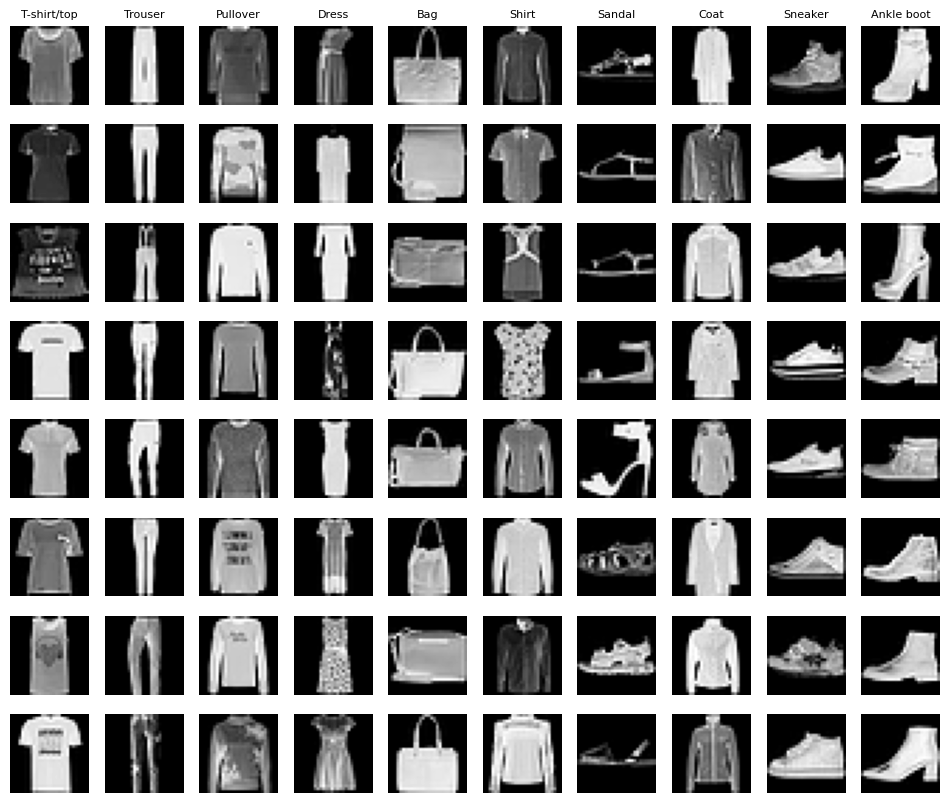

In [8]:
# function to plot the images
title ={0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal',
         6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

def plot_grid(n, df):
    labels = df['label'].unique()
    fig, axes = plt.subplots(n, len(labels), figsize=(12, 10))
    for j, label in enumerate(labels):
        selected_rows = df[df['label'] == label]
        for i in range(n):
            # print(i, j)
            selected_row = selected_rows.sample(1)
            axes[0, j].set_title(title[selected_row['label'].values[0]], fontsize=8)
            axes[i, j].imshow(selected_row.drop('label', axis=1).values.reshape(28,28), cmap='gray')
            axes[i, j].axis('off')
        
    return fig

fig = plot_grid(8, fashion_train)
fig.savefig('figures/0101.png')

### 2. Classify the dataset using neural networks, with two hidden layers. The number of nodes in the hidden layers is your choice, as discussed in class. Calculate the optimized weights and biases and training set accuracy for the model (take regularization parameter $\lambda$ = 0.1) 

* We will write the useful functions which will be used in the code.

`Cross Entropy`:

$$J = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{k}^{(i)} \log(\hat{y}_{k}^{(i)})$$

So let's write a class to calculate the loss and it's prime with respect to y_pred

In [9]:
# Loss function, we use the cross entropy loss function

class CategoricalCrossentropy:

    """
    Categorical cross-entropy loss function.
    """

    def __init__(self, l2 = 0) -> None:
        # by default we don't use regularization
        self.l2 = l2

    def loss(self, y_true, y_pred, ws):
        m_samples = y_pred.shape[1]

        # we use the log trick to avoid the underflow, (Catelogical cross entropy)
        cost = -np.sum(y_true * np.log(y_pred + 1e-10))   # shape = (batch_size,)

        cost = cost / m_samples  

        reg_term = 0
        reg_term += (self.l2/(2*m_samples)) * ws

        return cost + reg_term
    
    def loss_prime(self, y_true, y_pred):
        m_samples = y_pred.shape[1]

        # this is little bit different from the else loss_prime,
        # this return the (dJ/dA)*(dA/dz) so we don't need to find the derivative of sofmax_prime 
        cost_prime = (y_pred - y_true) / m_samples

        return cost_prime

- Now we will make a class for a fully connected layer in which we will be taking `# input nuerons` , `# output nuerons` , `l2 regularization` as an arguments

- Here we will save the input in the forward_propogation which will be used while backward_propogation in updating the weights and biases

- It is a fully connected DenseLayer

$$\mathbf{Z}^{[l]} = \mathbf{W}^{[l]} \mathbf{A}^{[l-1]} + \mathbf{b}^{[l]}$$

where $l$ is the layer number, $A^{[l-1]}$ is the activation of the previous layer, $W^{[l]}$ and $b^{[l]}$ are the weights and biases of the current layer.

$$ \mathbf{A}^{[0]} = \mathbf{X} \text{ (input data)}$$

$$ \mathbf{A}^{[L]} = \hat{\mathbf{Y}} \text{ (output predictions)}$$

In [10]:
# class for fully connected layer in the neural network
# it will initialize the weights and biases at the time of initialization
# and will also implement the forward and backward propagation

class DenseLayer:

    """
    Class for fully connected layer in the neural network.
    """

    def __init__(self, n_l_1, n_l, l2=0, bias=True):

        """
        Initialize the fully connected layer with weights and biases.

        Parameters
        ----------
        n_l_1: int
            Number of neurons in the input layer.

        n_l: int
            Number of neurons in the output layer.

        l2: float, optional
            L2 regularization parameter.

        bias: bool, optional
            Whether to use bias in the layer or not.

        """

        self.bias = bias

        
        self.weights = np.random.uniform(low=-1, high=1, size=(n_l, n_l_1))
        
        if self.bias:
            self.biases = np.random.uniform(
                low=-1, high=1, size=(n_l, 1)
            )  # biases  (n_[l], 1)
        else:
            self.biases = 0

        self.l2 = l2

        # Total Training parameters
        self.nuerons = n_l
        self.trainable_params = n_l * (n_l_1 + 1)

    def forward_propagation(self, activate_l_1):

        """
        Implement forward propagation through the fully connected layer.

        Parameters
        ----------
        activate_l_1: numpy.ndarray, shape (n_[l-1], batch_size)
            Input data to be propagated through the layer.

        Returns
        -------
        numpy.ndarray, , shape (n_[l], batch_size)
            Output of the layer after forward propagation.
        """
            
        
        # save the input for backpropagation
        self.input = activate_l_1  # activate (n_[l], batch_size)
        z_l = (
            np.dot(self.weights, self.input) + self.biases
        )  # z = weights x input + biases = (n_[l], n_[l-1]) x (n_[l-1], batch_size) + (n_[l], 1) = (n_[l], batch_size)


        self.output = z_l

        return self.output  # z (n_[l], batch_size)

    def backward_propagation(self, output_error, learning_rate):

        """
        Implement backward propagation through the fully connected layer.

        Parameters
        ----------
        output_error: numpy.ndarray
            Error in the output of the layer.

        learning_rate: float
            Learning rate to be used for weight updates.

        Returns
        -------
        numpy.ndarray
            Error to be propagated back to the previous layer.
        """

        # calculating the error with respect to weights before updating the weights
        input_error = np.dot(
            self.weights.T, output_error
        )  # weights x output_error  (n_[l], n_[l-1]) x (n_[l], batch_size) = (n_[l-1], batch_size)
        weights_error = np.dot(
            output_error, self.input.T
        )  # output_error x input    (n_l, batch_size) x (n_[l-1], batch_size) = (n_[l], n_[l-1])

        m_samples = output_error.shape[1]

        # addition of regularization term, by default both l1 and l2 are 0
        reg_term = (self.l2 / m_samples) * self.weights

        # updating the weights and biases
        self.weights -= learning_rate * (
            weights_error + reg_term
        )  # weights -= learning_rate * weights_error
        self.biases -= learning_rate * np.sum(
            output_error, axis=1, keepdims=True
        )  # biases -= learning_rate * output_error

        return input_error


- Let's write a class for the `Activation Layer`, we will be taking `activation class` as an argument which will be having two methods `activation` and `activation_prime`

$$\mathbf{A}^{[l]} = g^{[l]}(\mathbf{Z}^{[l]})$$

where $g^{[l]}$ is the activation function for layer $l$.

- in the backward_propogation we will be using the `activation_prime` to calculate the derivative of the activation function with respect to the `Z` which will be used in updating the weights and biases



In [11]:
# class for activation functions
# it will implement the forward and backward propagation
# we are going to use three activation functions
# 1. sigmoid
# 2. relu
# 3. softmax, this is used in the output layer


class Sigmoid:
    def activation(z):
        return 1 / (1 + np.exp(-z))

    def activation_prime(z):
        sigmoid_z = Sigmoid.activation(z)
        return sigmoid_z * (1 - sigmoid_z)
    

class ReLU:
    def activation(z):
        return np.maximum(0, z)

    def activation_prime(z):
        z[z <= 0] = 0
        z[z > 0] = 1
        return z
    
class Softmax:
    def activation(z):
        z -= np.max(
            z, axis=0, keepdims=True
        )  # axis=0 means coloumn z is the shape of (n_l, batch_size), axis=0 means the max value of each column b/c we are giving input as (n_l, batch_size)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def activation_prime(z):
        # we have calculated the dA/dz in the loss_prime itself,
        # that returns (dJ/dA)*(dA/dz) itself so no need to take the derivative of activation here
        return 1


    def softmax_derivative(z):
        softmax_ = Softmax.softmax(z)
        return np.einsum('ij,ik->ij', softmax_, (np.eye(z.shape[0]) - softmax_))



class ActivationLayer:

    """
    Activation layer for neural networks.
    This layer applies an non-linearity to the input data.

    activation (class) : (callable)
        The class of the activation function to be used. The class should have two methods:
        activation and activation_prime.
    """

    def __init__(self, activation):
        self.activation = activation.activation
        self.activation_prime = activation.activation_prime
        self.activation_name = activation.__name__

    def forward_propagation(self, z_l):

        """
        Perform the forward propagation of the activation layer.

        Parameters:
        z (numpy.ndarray): The z to the layer.

        Returns:
        numpy.ndarray: The output of the layer after applying the activation function.
        """

        self.input = z_l
        activate_l = self.activation(self.input)
        self.output = activate_l

        return self.output  # (n_[l], batch_size)

    def backward_propagation(self, output_error, learning_rate):

        """
        Perform the backward propagation of the activation layer.

        Parameters:
        -----------

        output_error (numpy.ndarray):
            The error that needs to be backpropagated through the layer.

        learning_rate (float):
            The learning rate used to update the weights.

        Returns:
        --------

        numpy.ndarray:
            The input error after backward propagation through the activation layer.
        """
        # if self.activation_prime == None:
        #     return output_error

        del_J_del_A_l = np.multiply(
            self.activation_prime(self.input), output_error
        )  # element-wise multiplication (n_[l], batch_size) x (n_[l], batch_size) = (n_[l], batch_size)

        return del_J_del_A_l



- Now we will write a class for the `Neural Network` which will be taking `layers` as an argument which will be a list of `DenseLayer` and `ActivationLayer` objects in the order in which they are to be stacked in the neural network.

- It have a method `predict` which will be used to predict the output for the given input

- In the `fit` method we will be taking `X_train` , `y_train` , `epochs` , `learning_rate` , `batch_size`  as an arguments and will be using the `Mini-Batch Gradient Descent` algorithm to update the weights and biases of the neural network

In [13]:
# Now we will create a function for the neural network
# we will use the Mini Batch Gradient Descent optimizer

class Network:


    def __init__(self, layers, use_loss):
        self.layers = layers
        self.loss_ = use_loss


    def get_dense_layers_w(self):
        l2_w = 0

        # calculating the regularization term for weights of all the dense layers at once
        for layer in reversed(self.layers):
            if layer.__class__.__name__ == "DenseLayer":
                if layer.l2 != 0:
                    l2_w += np.sum(np.power( layer.weights, 2))

        return l2_w

    #  predict output for given input
    def predict(self, input_data):

        """
        Predicts the output for a given input.

        Parameters:

        - input_data (numpy.ndarray):
            A 2D array of shape (m_samples, n_features) representing m_samples, each with n_features.

        Returns:

        - result (numpy.ndarray):
            A list of 2D arrays of shape (m_samples, n_classes) representing the predicted output for each of the m_samples. n_classes is the number of output nodes in the neural network.
        """

        # run network over all samples
        output = input_data.T
        for layer in self.layers:
            output = layer.forward_propagation(output)

        return output.T

    def fit(self, X, y, epochs=30, learning_rate=0.01, batch_size=64):
        """
        Train the neural network on the given data.

        Parameters:
        -----------

        X (numpy.ndarray):
            The input data.

        y (numpy.ndarray):
            The target data.

        epochs (int):
            The number of epochs to train the model.

        learning_rate (float):
            The learning rate used to update the weights.

        batch_size (int):
            Size of the batch for optimization purpose using Mini-Batch Gradient Descent

        Returns:
        --------

        list:
            The loss history.
        """

        # if no batch size is provided, use the entire training set in each batch
        if (batch_size is None) or (batch_size > X.shape[0]):
            batch_size = X.shape[0]

        # number of batches
        batches = X.shape[0] // batch_size

        if batches == 0:
            batches = 1

        # train network for given number of epochs



        loss_history = []
        for i in range(epochs):
            loss = 0

            # shuffle training data
            idx = np.random.permutation(X.shape[0])
            X = X[idx]
            y = y[idx]

            for j in range(batches):
                batch_start, batch_end = j * batch_size, (j + 1) * batch_size

                # forward propagation
                output = X[batch_start:batch_end].T  # shape (nx , batch_size)
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # backward propagation
                error = self.loss_.loss_prime(
                    y[batch_start:batch_end].T, output
                )  # shape (ny , batch_size)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)


            # for calculating loss we will need the regularized term also for that we will need the square of the weights
            ws = self.get_dense_layers_w()
            loss = self.loss_.loss(y.T, self.predict(X).T, ws)
            loss_history.append(loss)

            if i % 30 == 0:
                print("Epoch %d: loss = %.6f" % (i+1, loss))

        print("Epoch %d: loss = %.6f" % (i+1, loss))

        return loss_history


In [13]:
epochs = 500

layers_sigmoid = [
    # layer-1, nuerons in l=1 are 25
    DenseLayer(784, 25),
    # activation of the first hidden layer 'sigmoid'
    ActivationLayer(Sigmoid),

    # layer-2 (output-layer), nuerons in l=2 are 10
    DenseLayer(25, 10),
    # activation of the output layer 'Softmax
    ActivationLayer(Softmax)
]

# using l2 regularization , lambda_ = 0.1
loss_ = CategoricalCrossentropy(l2=0.1)

X_train = np.array(train_data)

y_oh = np.array(pd.get_dummies(train_labels))

net_sigmoid = Network(layers=layers_sigmoid, use_loss = loss_)

loss_history_sigmoid = net_sigmoid.fit(X_train, y_oh,  epochs=epochs, learning_rate=0.1, batch_size=128)

Epoch 1: loss = 1.768096
Epoch 31: loss = 0.605503
Epoch 61: loss = 0.507054
Epoch 91: loss = 0.451409
Epoch 121: loss = 0.413130
Epoch 151: loss = 0.383552
Epoch 181: loss = 0.359101
Epoch 211: loss = 0.340386
Epoch 241: loss = 0.320793
Epoch 271: loss = 0.305485
Epoch 301: loss = 0.293002
Epoch 331: loss = 0.281175
Epoch 361: loss = 0.268511
Epoch 391: loss = 0.257053
Epoch 421: loss = 0.247769
Epoch 451: loss = 0.236498
Epoch 481: loss = 0.227099
Epoch 500: loss = 0.222401


In [14]:
# optimized weights of both the layers are
ws = []
bs = []
for layer in net_sigmoid.layers:
    # as weights are only assigned in Dense Layer
    if layer.__class__.__name__ == "DenseLayer":
        ws.append(layer.weights)
        bs.append(layer.biases)

In [15]:
# we got the updated weights and biases for both the layers
len(ws), len(bs)

(2, 2)

In [16]:
# shape of the weights of the first layer is (25, 784) 
# which is equal to the 
# (# nuerons in 1st layer, # in 0th layer)
print(f"shape of updated weight matrix for first layer: {ws[0].shape}")
print(f"Shape fo updated bias matrix for layer-1: {bs[0].shape}")

shape of updated weight matrix for first layer: (25, 784)
Shape fo updated bias matrix for layer-1: (25, 1)


In [17]:
# updated weights of first hidden layer
ws[0]

array([[ 0.09733237,  0.64211612,  0.43141654, ..., -0.53945321,
         0.81917513,  0.59681227],
       [ 0.77455723, -0.13199028,  0.20723084, ..., -0.90124562,
        -0.89007832, -0.95372786],
       [ 0.71167367,  0.17812633,  0.02770294, ...,  0.77028119,
        -0.70029882,  0.61068796],
       ...,
       [ 0.93071593, -0.32512072,  0.29607617, ...,  0.58656734,
         0.07134936, -0.67555366],
       [-0.68944978, -0.60509642,  0.86117876, ...,  0.28476979,
        -0.06752638,  0.75877546],
       [-0.28574284, -0.12143406, -0.99376385, ..., -0.51540284,
         0.12914181,  0.27426143]])

In [18]:
# updated biases of the first hidden layer
bs[0]

array([[ 1.09723901],
       [-0.29439824],
       [ 0.80394569],
       [ 0.01250182],
       [ 0.34318807],
       [-1.40486849],
       [ 0.47254816],
       [-0.71311629],
       [-0.31973412],
       [ 0.35306136],
       [ 0.02699433],
       [-1.37653985],
       [ 0.25312773],
       [ 1.18998793],
       [-0.53779085],
       [-0.24061911],
       [-0.7950669 ],
       [-0.48210048],
       [ 0.25832759],
       [-0.81955931],
       [-0.0593232 ],
       [ 0.78373251],
       [ 1.69162866],
       [ 0.2379068 ],
       [-0.8356316 ]])

In [19]:
# shape of the weights of the first layer is (10, 25) 
# which is equal to the 
# (# nuerons in 2st layer, # in 1st layer)
print(f"shape of updated weight matrix for first layer: {ws[1].shape}")
print(f"Shape fo updated bias matrix for layer-1: {bs[1].shape}")

shape of updated weight matrix for first layer: (10, 25)
Shape fo updated bias matrix for layer-1: (10, 1)


In [20]:
# updated weights of second output layer
ws[1]

array([[ 0.11290728, -0.73596389,  0.4050369 ,  0.46426625,  0.65540828,
        -1.34739548, -0.61285109, -1.00100304,  3.10525184, -1.18113138,
         0.66015744, -0.70502139,  3.12087622,  0.37795869,  0.66491928,
        -1.80328058, -1.3282877 , -3.10456868,  0.13783313,  1.92478699,
         0.27183049,  2.00879265,  1.52221241, -2.02403651,  0.25395373],
       [-1.54562005, -0.20638878, -0.348165  , -0.34103725,  0.87210302,
         1.04816026,  1.88281693,  0.98308368,  1.81843303, -1.30465478,
         2.70555711,  0.28431172, -1.97828873, -1.36997497,  1.14393686,
         2.51066537, -1.08516524, -0.35724532, -1.66683343, -0.55909382,
        -0.17353568, -2.3740337 , -2.81547431,  0.69125776,  0.18914549],
       [-0.12225915, -0.95702656, -1.10965318, -0.0831147 , -0.8235191 ,
         0.32138424,  1.70523733, -1.97878828, -2.08489432,  1.9851954 ,
        -0.98843607,  1.67933124,  1.92885814, -1.8174385 ,  0.36214101,
         1.55380725, -0.20084358, -2.81469043, -0

In [21]:
# updated biases of second output layer
bs[1]

array([[ 0.44534412],
       [-0.79213455],
       [ 0.37066372],
       [-0.52492353],
       [ 0.07146499],
       [ 0.34065735],
       [ 0.62387333],
       [ 0.10975186],
       [ 0.05616478],
       [-0.50877056]])

### 3. Implement sigmoid and ReLu activation functions and see which performs best. Add a SoftMax activation for the output layer for both cases

In [23]:
# lets write a function to check the accuracy of the model

def accuracy( y_true, y_pred):

        """
        Calculates the accuracy of the model.

        Parameters:

        - y_true (numpy.ndarray):
            A 1D array of shape (m_samples, ) representing m_samples each with it's label output.

        - y_pred (numpy.ndarray):
            A 1D array of shape (m_samples, ) representing m_samples each with it's label output.

        Returns:

        - result (float):
            The accuracy of the model.

        """

        return np.mean(y_true == y_pred)

In [23]:
# for the sigmoid as the activation in the hidden layer

prob_sigmoid = net_sigmoid.predict(X_train)
prob_sigmoid[:4]

array([[8.26184805e-01, 5.66628571e-08, 1.74792819e-05, 7.77351227e-05,
        9.73987035e-07, 8.70738127e-07, 1.73715679e-01, 3.65648925e-10,
        2.39910652e-06, 2.00332882e-10],
       [6.94150161e-06, 9.99400130e-01, 1.12551605e-06, 5.73252793e-04,
        1.23867694e-06, 5.96798627e-08, 6.82566342e-07, 1.45606242e-05,
        1.96286832e-06, 4.61121590e-08],
       [2.41388252e-02, 3.91104682e-05, 9.23365325e-01, 7.10811673e-05,
        9.72346062e-04, 1.47407018e-03, 4.99076800e-02, 1.13843251e-07,
        3.11124708e-05, 3.35419241e-07],
       [1.94917520e-01, 4.17640340e-04, 6.42055622e-01, 7.62125840e-05,
        3.68218522e-05, 1.07539113e-04, 1.47720867e-01, 2.09038791e-07,
        1.46625613e-02, 5.00680766e-06]])

In [24]:
# as the above prediction is the prediction done by softmax which is the probability of each sample belonging to each class
# so let's take the final label as whose probability is maximum

def predict_classes( probability):

        """
        Predicts the class for a given input.

        Parameters:

        - probability (numpy.ndarray):
            A 2D array of shape (m_samples, n_features) representing m_samples, each with n_features.

        Returns:

        - result (numpy.ndarray):
            A list of 1D arrays of shape (m_samples, ) representing the predicted output for each of the m_samples.

        """

        return np.argmax(probability, axis=1)

pred_sigmoid = predict_classes(prob_sigmoid)

# so the accuracy is 
acc_sigmoid = accuracy(train_labels, pred_sigmoid)
print(f"Accuracy when sigmoid is used as activation for hidden layer: {acc_sigmoid}")

Accuracy when sigmoid is used as activation for hidden layer: 0.9283


- Let's train another model for the same parameters except changing the activation function of the Hidden layer from `sigmoid to relu`

In [25]:
epochs = 500

layers_relu = [
    # layer-1, nuerons in l=1 are 25
    DenseLayer(784, 25),
    # activation of the first hidden layer 'sigmoid'
    ActivationLayer(ReLU),

    # layer-2 (output-layer), nuerons in l=2 are 10
    DenseLayer(25, 10),
    # activation of the output layer 'Softmax
    ActivationLayer(Softmax)
]

# using l2 regularization , lambda_ = 0.1
loss_ = CategoricalCrossentropy(l2=0.1)

X_train = np.array(train_data)

y_oh = np.array(pd.get_dummies(train_labels))

net_relu = Network(layers=layers_relu, use_loss = loss_)

loss_history_relu = net_relu.fit(X_train, y_oh,  epochs=epochs, learning_rate=0.1, batch_size=128)

Epoch 1: loss = 1.223734
Epoch 31: loss = 0.521665
Epoch 61: loss = 0.443733
Epoch 91: loss = 0.402446
Epoch 121: loss = 0.371652
Epoch 151: loss = 0.344593
Epoch 181: loss = 0.322664
Epoch 211: loss = 0.303782
Epoch 241: loss = 0.278880
Epoch 271: loss = 0.265714
Epoch 301: loss = 0.251578
Epoch 331: loss = 0.232198
Epoch 361: loss = 0.218083
Epoch 391: loss = 0.202282
Epoch 421: loss = 0.198848
Epoch 451: loss = 0.178804
Epoch 481: loss = 0.172237
Epoch 500: loss = 0.165275


In [26]:
# for the relu as the activation in the hidden layer

prob_relu = net_relu.predict(X_train)
prob_relu[:4]

# get the argmax as the predicted class

pred_relu = predict_classes(prob_relu)

In [27]:
acc_relu = accuracy(train_labels, pred_relu)
print(f"Accuracy when relu is used as activation for hidden layer: {acc_relu}")

Accuracy when relu is used as activation for hidden layer: 0.9419


### 4. Apply the trained model algorithm on the normalized test dataset and predict the testing accuracy of the model for both sets of activation functions (Use the optimized weights calculated using training data).

In [28]:
# 2. for sigmoid as activation of hidden layer

X_test = np.array(test_data)

prob_sigmoid = net_sigmoid.predict(X_test)
prob_sigmoid[:4]

# get the argmax as the predicted class

pred_sigmoid = predict_classes(prob_sigmoid)

acc_sigmoid = accuracy(test_labels, pred_sigmoid)
print(f"Test Accuracy for sigmoid as activation : {acc_sigmoid}")

Test Accuracy for sigmoid as activation : 0.8333333333333334


In [29]:
# let's check the accuracy for both the models

# 1. for relu as activation of hidden layer

X_test = np.array(test_data)

prob_relu = net_relu.predict(X_test)
prob_relu[:4]

# get the argmax as the predicted class

pred_relu = predict_classes(prob_relu)

acc_relu = accuracy(test_labels, pred_relu)
print(f"Test Accuracy for relu as activation : {acc_relu}")

Test Accuracy for relu as activation : 0.9


- Here we can see that test accuracy is better for `relu` activation function than `sigmoid` activation function.

### 5. Use the test data to plot few images along with the model-prediction labels/classes

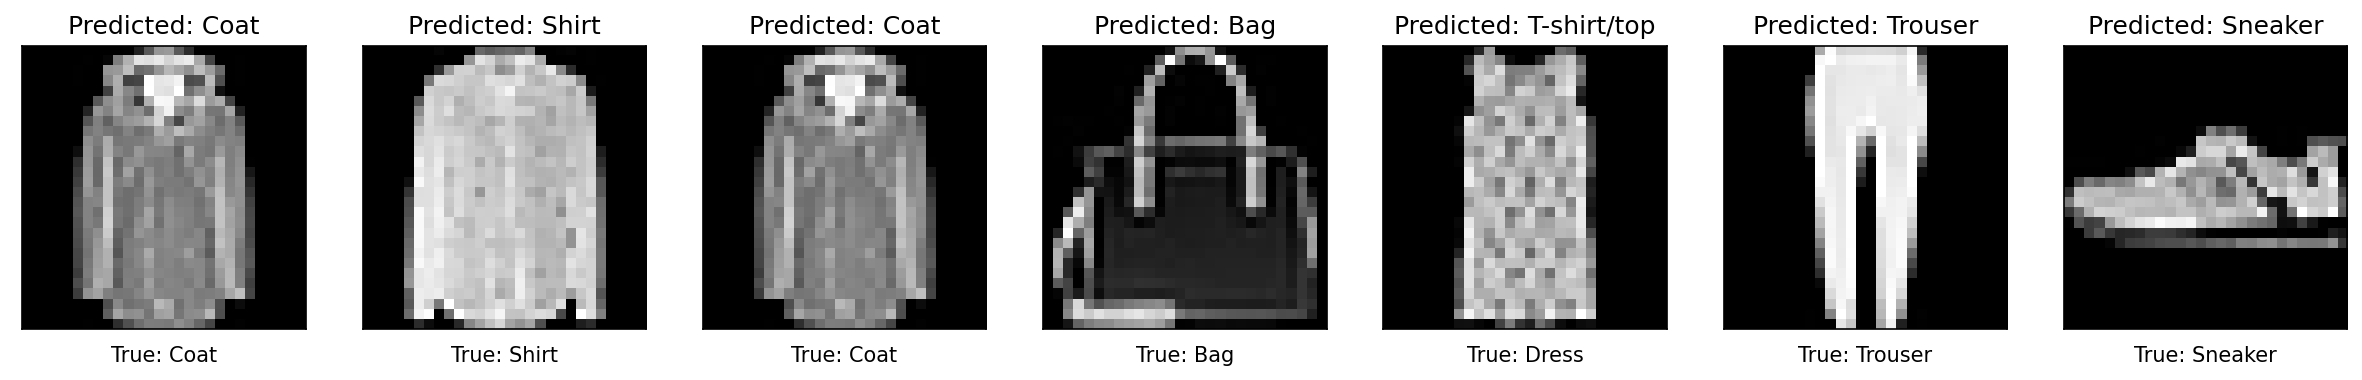

In [36]:
# function to plot n random images from the dataset X and y, and prints the predicted and true labels.

def plot_random_images( X, y, n=10):
    
            """
            Plots n random images from the dataset X and y, and prints the predicted and true labels.
    
            Parameters:
    
            - X (numpy.ndarray):
                A 2D array of shape (m_samples, n_features) representing m_samples, each with n_features.
    
            - y (numpy.ndarray):
                A 1D array of shape (m_samples, ) representing m_samples each with it's label output.
    
            - n (int):
                Number of images to plot.
    
            Returns:
    
            - None
    
            """
            titles ={0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal',
         6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
    
            # get n random indices
            indices = np.random.randint(0, len(X), n)
    
            # get the images and labels
            images = X[indices]
            labels = y[indices]
    
            # plot the images
            fig, axes = plt.subplots(1, n, figsize=(20, 15), dpi=150)
            for i in range(n):
                axes[i].imshow(images[i].reshape(28, 28), cmap="gray")
                axes[i].set_title(f"Predicted: {titles[pred_relu[indices[i]]]}")
                axes[i].set_xlabel(f"True: {titles[labels[i]]}")
                axes[i].set_xticks([])
                axes[i].set_yticks([])
            return fig

fig = plot_random_images(X_test, np.array(test_labels), n=7)
fig.savefig("figures/0102.png")

### 6. Compare how the two NNs fare in terms of prediction accuracy for the same number of optimisation iterations and comment what you can conclude from that

- We can see that for both the NN models the accuracy in `training data` is good for `relu model` and it's loss is also far less than the `sigmoid model`. 

- For `Test data` also the accuracy is better for `relu model` than `sigmoid model`.

- So we can conclude that `relu` activation function is better than `sigmoid` activation function for this dataset.

### 7. Plot the evolution of cost function over optimization iterations 

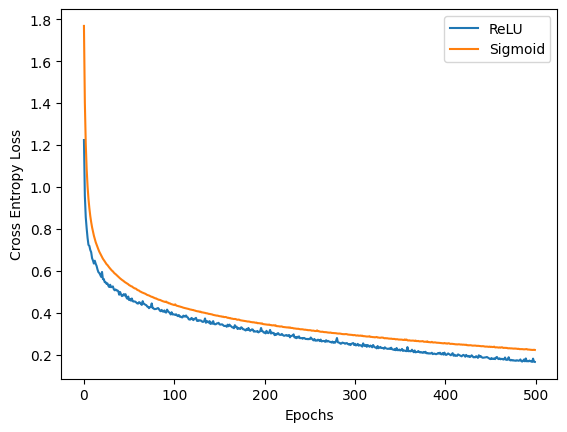

In [37]:
plt.plot(loss_history_relu, label="ReLU")
plt.plot(loss_history_sigmoid, label="Sigmoid")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend();
plt.savefig("figures/0103")

- So here we can see that for the case of `relu` activation function the cost function is much less than the `sigmoid` activation function.

- For test data also the cost function is less for `relu` activation function. Hence it is not overfitting also.

# Binary Classification with Nonlinear Decision Boundary

### 1. Use the following code snippet to generate a ‘Binary Classification’ dataset

In [43]:
import sklearn
import sklearn.datasets
X, y = sklearn.datasets.make_moons(500, noise=0.30)
import matplotlib.pyplot as plt

### 2. Write a Neural Network code to do Binary Classification using Non-linear Logistic Regression and plot the decision boundary with scattered data-points in the same plot.

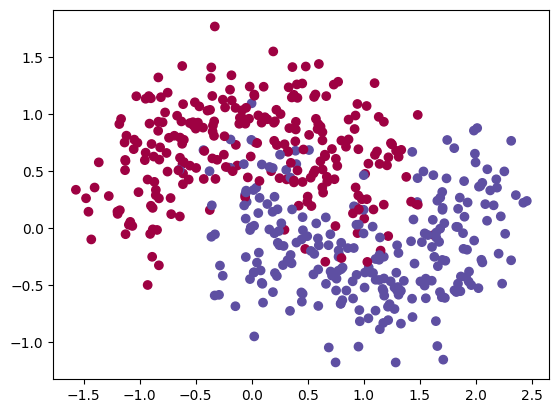

In [58]:
# let's plot the data

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral);
plt.savefig("figures/0201.png")

In [59]:
# Shape of the data
X.shape, y.shape

((500, 2), (500,))

In [60]:
X[:5]

array([[ 2.01195691,  0.87994481],
       [ 0.453865  ,  0.09750076],
       [-1.18169774,  0.91518011],
       [ 1.10456925, -0.27015104],
       [-0.05964959,  0.29316558]])

In [61]:
# Lets add the quadratic features to the data
# i.e x1^2, x2^2, x1*x2

X_ = np.hstack((X, X[:, 0:1] ** 2, X[:, 1:2] ** 2, X[:, 0:1] * X[:, 1:2]))

In [62]:
X_[:5]

array([[ 2.01195691e+00,  8.79944813e-01,  4.04797062e+00,
         7.74302874e-01,  1.77041105e+00],
       [ 4.53864999e-01,  9.75007584e-02,  2.05993438e-01,
         9.50639789e-03,  4.42521816e-02],
       [-1.18169774e+00,  9.15180113e-01,  1.39640955e+00,
         8.37554639e-01, -1.08146627e+00],
       [ 1.10456925e+00, -2.70151045e-01,  1.22007323e+00,
         7.29815870e-02, -2.98400537e-01],
       [-5.96495902e-02,  2.93165581e-01,  3.55807362e-03,
         8.59460579e-02, -1.74872068e-02]])

In [63]:
# new shape of the data
X_.shape

(500, 5)

In [64]:
# we will need this time BinaryCrossentropy loss


class BinaryCrossentropy:

    """
    Binary cross-entropy loss function.
    """

    def __init__(self, l2 = 0) -> None:
        # by default we don't use regularization
        self.l2 = l2

    def loss(self, y_true, y_pred, ws):
        m_samples = y_pred.shape[1]
        cost = (
            -np.sum(
                y_true * np.log(y_pred + 1e-10)
                + (1 - y_true) * np.log(1 - y_pred + 1e-10)
            )
            / m_samples
        )

        reg_term = 0
        reg_term += (self.l2/(2*m_samples)) * ws
        
        return cost + reg_term

    def loss_prime(self, y_true, y_pred):
        m_samples = y_pred.shape[1]

        cost_prime = ((y_pred - y_true) / (y_pred * (1 - y_pred + 1e-10))) / m_samples

        return cost_prime 

    

In [65]:
# Loss function, we use the cross entropy loss function

class CategoricalCrossentropy:

    """
    Categorical cross-entropy loss function.
    """

    def __init__(self, l2 = 0) -> None:
        # by default we don't use regularization
        self.l2 = l2

    def loss(self, y_true, y_pred, ws):
        m_samples = y_pred.shape[1]

        # we use the log trick to avoid the underflow, (Catelogical cross entropy)
        cost = -np.sum(y_true * np.log(y_pred + 1e-10))   # shape = (batch_size,)

        cost = cost / m_samples  

        reg_term = 0
        reg_term += (self.l2/(2*m_samples)) * ws

        return cost + reg_term
    
    def loss_prime(self, y_true, y_pred):
        m_samples = y_pred.shape[1]

        # this is little bit different from the else loss_prime,
        # this return the (dJ/dA)*(dA/dz) so we don't need to find the derivative of sofmax_prime 
        cost_prime = (y_pred - y_true) / m_samples

        return cost_prime

In [66]:
# let's train the model

# As this is a binary classification problem, we will use the sigmoid activation function in the output layer.
# and loss function will be binary cross entropy

epochs = 100


layers = [
    # layer-1, nuerons in l=1 are 25
    DenseLayer(5, 25),
    # activation of the first hidden layer 'Relu'
    ActivationLayer(ReLU),

    DenseLayer(25, 25),
    # activation of the second hidden layer 'Relu'
    ActivationLayer(ReLU),

    # layer-2 (output-layer), nuerons in l=2 are 1
    DenseLayer(25, 1),
    # activation of the output layer 'sigmoid'
    ActivationLayer(Sigmoid)
]

# using l2 regularization , lambda_ = 0.1
loss_ = BinaryCrossentropy(l2=0.1)

nn = Network(layers, use_loss=loss_)

# train the model
loss_history = nn.fit(X_, y, epochs=epochs, learning_rate=0.1, batch_size=64)

Epoch 1: loss = 0.430707
Epoch 31: loss = 0.229047
Epoch 61: loss = 0.202407
Epoch 91: loss = 0.201230
Epoch 100: loss = 0.198676


In [67]:
pred = nn.predict(X_)

pred_class = np.where(pred > 0.5, 1, 0)

# accuracy 
accuracy(y, pred_class.reshape(-1))

0.922

In [68]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole gid

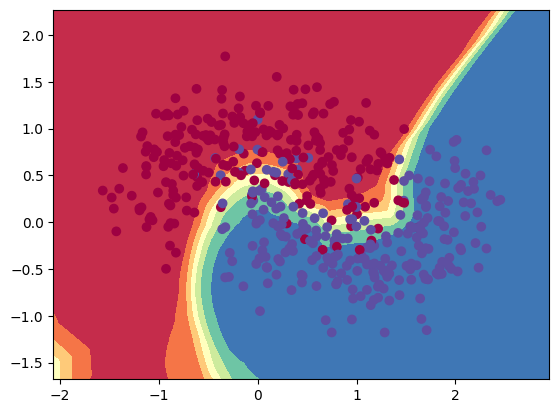

In [69]:
# Plot the boundary

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Add the quadratic features to the data
    final_X = np.hstack((np.c_[xx.ravel(), yy.ravel()], np.c_[xx.ravel(), yy.ravel()] ** 2, (xx.ravel()*yy.ravel()).reshape(-1,1) ))
    # Predict the function value for the whole gid
    Z = model.predict(final_X)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    return fig

fig = plot_decision_boundary(nn, X, y)
fig.savefig("figures/0202.png")

- Here we can see that our model is able to classify the data sets very efficiently. Only problem it is facing is at the boundary as few of the points of blue are present in the red.

---
---
---

# Extra

- I have also made a whole `API` for the implementation of the `Neural Network` which can be used for any dataset. It can be found inside the `nueral` folder.

- There I have 5 py files which are as follows:

1. `activations.py` : It contains the activation functions and their derivatives.

2. `layers.py` : It contains the `DenseLayer` and `ActivationLayer` classes.

3. `losses.py` : It contains the `Loss` class which is used to calculate the loss and it's derivative with respect to the `y_pred`

4. `metrics` : It contains the `Accuracy` class which is used to calculate the accuracy of the model.

5. `nn.py` : It contains the `NeuralNetwork` class which is used to create the neural network model.

---

- In `activations.py` I have implemented the following activation functions which can be used in the `ActivationLayer` class:

1. `tanh`: $$\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

2. `relu`: $$\text{relu}(x) = \max(0, x)$$

3. `linear`: $$\text{linear}(x) = x$$

4. `sigmoid`: $$\sigma(x) = \frac{1}{1 + e^{-x}}$$

5. `hard_sigmoid`: $$\text{hard\_sigmoid}(x) = \begin{cases} 0 & x < -2.5 \\ \frac{1}{5}x + 0.5 & -2.5 \leq x \leq 2.5 \\ 1 & x > 2.5 \end{cases}$$

6. `softmax`: $$\text{softmax}(x) = \frac{e^{x}}{\sum_{i=1}^{n} e^{x_{i}}}$$

---

- In `layers.py` I have implemented the following classes:

1. `DenseLayer`: It is a fully connected layer which takes `# input nuerons` , `# output nuerons` ,  `l1 and l2 regularization` as an arguments. 

-It also take `activation class's object` as an argument which can be used for the activation purpose if we don't want to use the `ActivationLayer` class. 

- It also take the type of initialization of the weights and biases as an argument which can be `he` or `xavier` or `random` or `zeros` or `ones`.

2. `ActivationLayer`: It takes the activation class's object as an argument which can be any activation. It is `callable` so we can use a self defined activation function also which is not present in the `activations.py` file.

3. `DropoutLayer`: It takes the `dropout_rate` as an argument which is the probability of the neuron to be dropped. It just sets the output of the neuron to zero with the given probability.

- It can be used as a regularizer to prevent overfitting.

---

- In `losses.py` I have implemented the following classes:

1. `MSE`: It is the `Mean Squared Error` loss function which is used for regression problems. It takes the `y_true` and `y_pred` as an arguments and returns the `loss` and `derivative` of the loss with respect to the `y_pred`.

2. `MAE`: It is the `Mean Absolute Error` loss function which is used for regression problems. It takes the `y_true` and `y_pred` as an arguments and returns the `loss` and `derivative` of the loss with respect to the `y_pred`.

3. `BinaryCrossEntropy`: It is the `Binary Cross Entropy` loss function which is used for binary classification problems. It takes the `y_true` and `y_pred` as an arguments and returns the `loss` and `derivative` of the loss with respect to the `y_pred`.

4. `CategoricalCrossEntropy`: It is the `Categorical Cross Entropy` loss function which is used for multi-class classification problems. It takes the `y_true` and `y_pred` as an arguments and returns the `loss` and `derivative` of the loss with respect to the `y_pred`.

---

- In `metrics.py` I have implemented the following classes:

1. `Accuracy`: It is used to calculate the accuracy of the model. It takes the `y_true` and `y_pred` as an arguments and returns the `accuracy`.

2. `Precision`: It is used to calculate the precision of the model. It takes the `y_true` and `y_pred` as an arguments and returns the `precision`.

3. `Recall`: It is used to calculate the recall of the model. It takes the `y_true` and `y_pred` as an arguments and returns the `recall`.

4. `F1Score`: It is used to calculate the `F1 Score` of the model. It takes the `y_true` and `y_pred` as an arguments and returns the `F1 Score`.

5. `r2_score`: It is used to calculate the `r2_score` of the model. It takes the `y_true` and `y_pred` as an arguments and returns the `r2_score`.

6. `confusion_matrix`: It is used to calculate the `Confusion Matrix` of the model. It takes the `y_true` and `y_pred` as an arguments and returns the `Confusion Matrix`.

---

- In `nn.py` I have implemented the following classes:

1. `NeuralNetwork`: It is the main class which is used to create the neural network model. 

- let's implement a simple neural network model for the `Classification` problem.


- import the important libraries from the `nueral` folder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from  neural.nn import NeuralNetwork
from  neural.layers import ActivationLayer, DenseLayer, DropoutLayer
from  neural.losses import CategoricalCrossentropy
from neural.activations import Sigmoid, ReLU, Softmax
from neural.metrics import Metrics

- let's train a classification model on the `Fashion-MNIST` dataset.

In [2]:
df = pd.read_csv('data/fashion-mnist_train.csv')
y_train = df['label'].values
x_train = df.drop('label', axis=1).values/255.

test_df = pd.read_csv('data/fashion-mnist_test.csv')
y_test = test_df['label'].values
x_test = test_df.drop('label', axis=1).values/255.

In [3]:
# define a callback function to calculate different metrics

precisions_ = []
accuracies_ = []
recalls_ = []
f1s_ = []
losses_ = []


def callback(true, predicted, loss, epoch):
    losses_.append(loss)
    pred  = Metrics.predict_classes(predicted)
    # print(pred.shape)
    global precisions_
    global accuracies_
    global recalls_
    global f1s_
    precisions_.append(Metrics.precision(true, pred))
    accuracies_.append(Metrics.accuracy(true, pred))
    recalls_.append(Metrics.recall(true, pred))
    f1s_.append(Metrics.f1_score(true, pred))

- Fianlly let's create our model

In [4]:
# make a instance of the NeuralNetwork class
model = NeuralNetwork()

# add first-layer to the model with 25 neurons and relu activation function
model.add(DenseLayer(28*28, 25, activation="relu"))              

# add second-droupout-layer to the model for regularization with 0.2 dropout rate
# model.add(DropoutLayer(dropout_rate=0.2))

# add output-layer to the model with 10 neurons and softmax activation function
model.add(DenseLayer(25, 10, activation="softmax"))                   

# use categorical cross entropy as loss function, we can give the l2 regularization term as well
model.use_loss(CategoricalCrossentropy(l2=0.1))

# Print the model summary
model.summary()

Summary of the Neural Network
___________________________________________________________________________________________________________________
Layer (type)        Neurons #      Input Shape    Output Shape   Weights shape  Bias shape        Param #
Input               784            -              (784, None)    -              -                       0

DenseLayer          25             (784, None)    (25, None)     (25, 784)      (25, 1)             19625

DenseLayer          10             (25, None)     (10, None)     (10, 25)       (10, 1)               260

Total params                                                                                        19885


In [5]:
# one-hot encode the labels as this is a multiclass classification problem
y_oh = np.array(pd.get_dummies(y_train))

model.fit(x_train, y_oh, epochs=500, learning_rate=0.01,  batch_size=128, verbose=1, callback=callback)

Epoch 1-500 ======================> cost: 1.7929
Epoch 11-500 ======================> cost: 0.7316
Epoch 21-500 ======================> cost: 0.6176
Epoch 31-500 ======================> cost: 0.5529
Epoch 41-500 ======================> cost: 0.5135
Epoch 51-500 ======================> cost: 0.4885
Epoch 61-500 ======================> cost: 0.4667
Epoch 71-500 ======================> cost: 0.4515
Epoch 81-500 ======================> cost: 0.4373
Epoch 91-500 ======================> cost: 0.4261
Epoch 101-500 ======================> cost: 0.4205
Epoch 111-500 ======================> cost: 0.4054
Epoch 121-500 ======================> cost: 0.3981
Epoch 131-500 ======================> cost: 0.3906
Epoch 141-500 ======================> cost: 0.3837
Epoch 151-500 ======================> cost: 0.3772
Epoch 161-500 ======================> cost: 0.3709
Epoch 171-500 ======================> cost: 0.3627
Epoch 181-500 ======================> cost: 0.3600
Epoch 191-500 ======================> cost

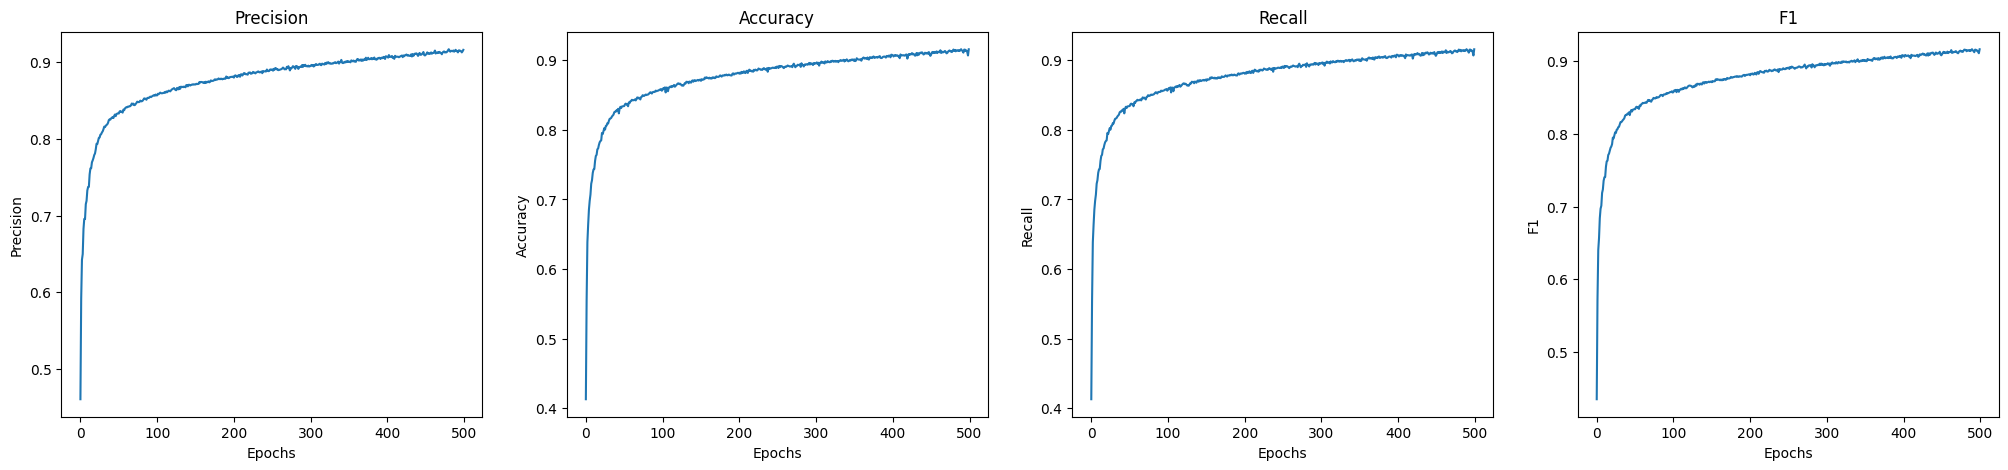

In [6]:
def plot_metrics(metrics, titles):
    # plot all the metrics in one plot

    fig, ax = plt.subplots(1, len(metrics), figsize=(25, 5))
    if len(metrics) == 1:
        ax = [ax]

    for i, metric in enumerate(metrics):
        ax[i].plot(metric)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(titles[i])
    plt.show()

plot_metrics([precisions_, accuracies_, recalls_, f1s_], ["Precision", "Accuracy", "Recall", "F1"])

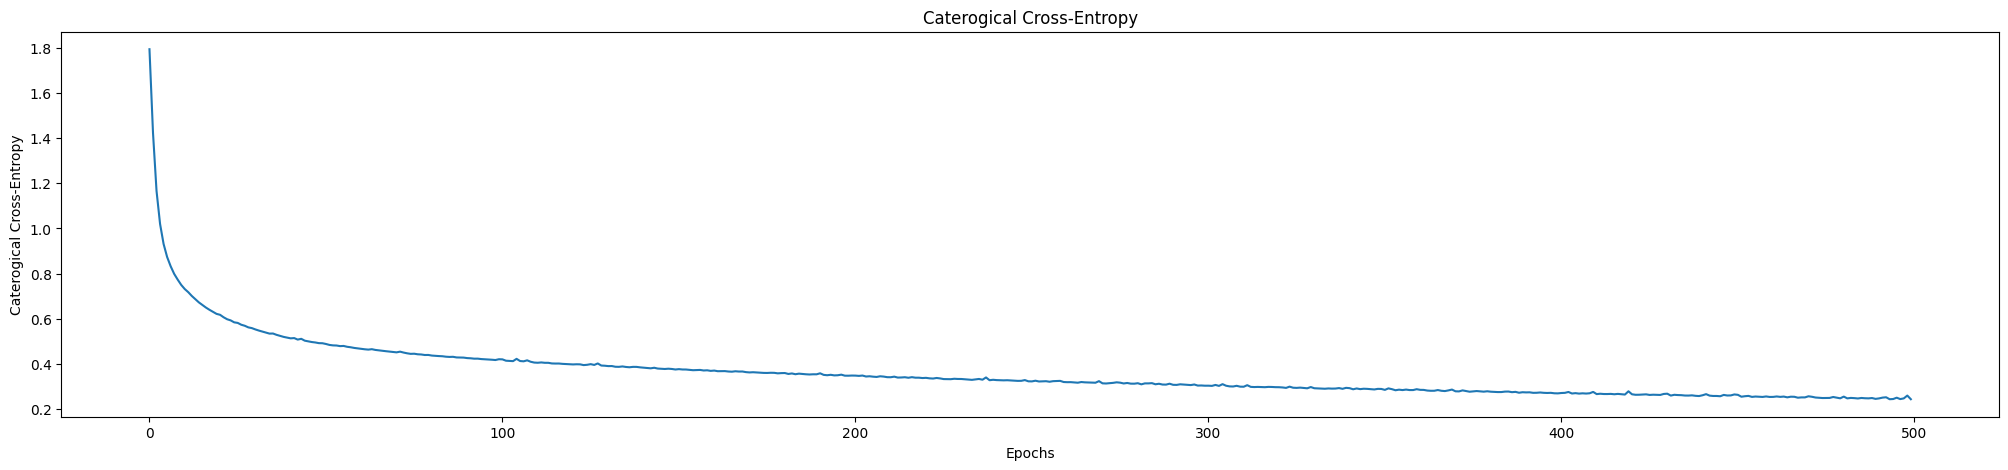

In [7]:
plot_metrics([losses_], ["Caterogical Cross-Entropy"])

- So here we can see that `Precision`, `Accuracy`, `Recall` and `F1 Score` are all increasing with the epochs.

and `Loss` is decreasing with the epochs.

so our model is learning. it can be trained for more epochs to get better results.

In [8]:
# let's see the accuracy on the training set

print(f"Training Accuracy: {accuracies_[-1]}")

Training Accuracy: 0.9159


In [9]:
prob_test = model.predict(x_test)
test_pred = Metrics.predict_classes(prob_test)
print("Test Accuracy: ", Metrics.accuracy(y_test, test_pred))

Test Accuracy:  0.9


- As we can see that it is well performing on the test data and can be trained for more epochs also as it is not overfitting.